In [1]:
##Demonstration for optimization of boundary conditions to minimize <dH/dx>, average variation in pressure head 
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from writeit import rewritePipes
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
##Set up initial conditions and various parameters. Three test cases (described in paper) are available below
case =1; #case =1,2, or 3. Corresponds to test cases (I), (II), and (III) from paper
Ds = [1.]*3  #pipe diameters
jt = [1,3,1,1] #junction types
bt = [1,1,1,1] #boundary types
bv = [0,0,0,0] #boundary values
r = [0,0,1,1]  #reflect 
elevs =[0,0,0,0]#elevations
ndof =15    #degrees of freedom for optimization
mult = 2
#case (I)
if case==1:
    Ls = [100,100,25] #lengths
    Ns = [100,100,25] #number of grid cells
    T = 60.     #final time
    M = 7500*mult   #number of time steps
    dt = T/M
    a = 100
    h0s = [0,0,0]   #initial water heights in each pipe
    q0s = [0,0,0]   #initial discharge in each pipe
    Mrs = [0.015]*3  #manning roughness coeffs
    md = 0           #mode for interpolation (0 =Hermite)
    Q00 = 2.*np.ones(M+1)  #time series for Q(x=0,t) for node being optimizaed over)
    Vin = dt*sum(Q00)  #inflow volume
    x0 = np.zeros(ndof)  
    for i in range((ndof-1)/2):
        x0[2*i+1]= Vin/T
#Case(II) and (III) differ only in a
if case >1:
    Ls = [100,100,50]
    Ns = [200,200,100]
    Mrs = [0.008]*3
    x0 = np.array([0.,0.,0.,0., 0.,0.,0.,0.,1.591549430918954,0.,0.530516476972984,0.,0.318309886183791,0.,0.227364204416993])
    #x0 = np.array([0.,0.,0.,0., 0.,0.,0.,0., 0.,0.,0.,0, 0.,0.,0.,0.,\
    #               1.591549430918954,0.,0.530516476972984,0.,0.318309886183791,0.,0.227364204416993,\
    #               0.,0.17683882565,0., 0.1446863119 , 0., 0.1224268793 ,0., 0.10610329539   ])
    if case==2:#Case(II)
        a = 10
        T = 120
        Vin = 150
        M = 4000*mult
        Q00 = np.zeros(M+1)
        for i in range(M+1/2):
            Q00[i] = Vin/T
        h0s = [10,0,0]
        q0s = [5,0,0]
        md = 1
    elif case ==3:#Case(III)
        a =100
        T = 16
        M = 3600*mult
        Vin = 20
        Q00 = np.zeros(M+1)
        for i in range(M+1/2):
            Q00[i] = Vin/T
        h0s = [10,0,0]
        q0s = [2.5,0,0]
        md = 1
        



In [24]:
#x0= np.array([0.011079696485735,   2.552967350903286,  -0.052790523608485,   2.496799960817641,   0.027911116042672,\
#     2.494589236059767, 0.013933565390256,   2.436916318621484,    -0.074060118101019,  2.410513952765013,\
#    -0.062699631460831, -2.687539185883663,    -1.140300988520731,   0.313049865386880,    1.429338969101706])


In [25]:
fn = "../indata/dhoptimization"  #base name of new .inp and .config files 
oldinp = "../indata/better3pipes.inp" #old .inp file used to determine network connectivity
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a,elevs)
mtype =1
n0 = PyNetwork(fi, fc, mtype)
M = n0.M


In [26]:
dt = n0.T/n0.M
V0 = n0.getTotalVolume()#get initial volume
n0.setbVal(0,Q00)        #set boundary value time series at node 0 to Q00
n0.runForwardProblem(dt)  #solve up to time T
Vf = n0.getTotalVolume()  #get final volume


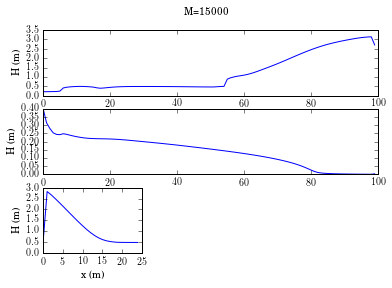

In [27]:
#plot the water height in each pipe at time T
from matplotlib import gridspec
hi = [n0.getHofA(i) for i in range(3)]
#fig,ax = plt.subplots(nrows = n0.Nedges, figsize= (10,5))
x00 = [0,0,0]
#ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)

for k in range(n0.Nedges):
    x = np.arange(0,n0.Ls[k], n0.Ls[k]/n0.Ns[k])+x00[k]*np.ones(size(hi[k]))
    H = n0.pressureSpaceSeries(k,M)
    if k<2:
        cspan=4
    else:
        cspan=1
    ax = plt.subplot2grid((3,3), (k,0), colspan=cspan)
    ax.plot(x,H,'b')
    gca().set_ylabel('H (m)')
gca().set_xlabel('x (m)')
suptitle('M=%d'%M)
dx = n0.Ls[0]/n0.Ns[0]
savefig('/Users/lieba/Desktop/solutionH_M%d.eps'%M)

CFL = 0.266667 
space-average grad(H)
        Q = 0       reflecting
max  1.846703  
mean 26.609089  


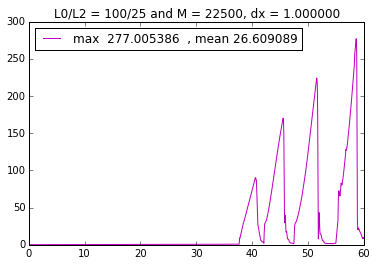

In [7]:
#plot the gradient pressure head at over time
print "CFL = %f " %(dt/dx*n0.a[0])
Hbar = [n0.getAveGradH(i) for i in range(n0.M+1)]
t = np.linspace(0,n0.T,n0.M+1)
kk = 1
plot(t,Hbar,'m')
legend(["max  %f  , mean %f" %(max(Hbar),mean(Hbar))], loc ='upper left')
#savefig("../../gradH_r66.pdf", format='pdf')
title("L0/L2 = %.f/%.f and M = %d, dx = %f"%(n0.Ls[0],n0.Ls[2], n0.M, n0.Ls[0]/n0.Ns[0]))
print "space-average grad(H)"
print "        Q = 0       reflecting"
print "max  %f  " %(max(Hbar)/sqrt(n0.M))
print "mean %f  " %(mean(Hbar))
dx = n0.Ls[0]/n0.Ns[0]


In [8]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [8]:
Mstart = 15000

#optimal solution for M = 7500
if Mstart==7500:
    x0 = np.array([ 0.001104467015525,   2.003837895658089,   -0.004644045391606,   1.997175965146338,   -0.023331482749487,\
   1.999186920724476,   -0.004431457428225,   2.001297246462507,   -0.001088129079379,   2.001414344330595,\
   -0.002074450582142,   2.000853623702620,   -0.001326299989290,   1.999803945461978,   0.000805467534120])
#optimal solution for M = 15000
elif Mstart ==15000:
    x0 = np.array([   0.196373689783578,  1.284624749675717, -3.135561017062915, 2.911496290652327,   -0.212268261676944,\
  1.823137160142219, 0.111416767094591, 1.990141852896665,  -0.032064798946064,  1.969530699120267,\
   -0.120847998899830,   2.114570563072279,   -0.009206054403212,  2.263814772519339,  0.530362267445412])
#optimal solution for M =22500
elif Mstart ==22500:
    x0 = np.array([0.272470224779243,2.112963891559315,0.015607557740878,1.951650261241615,-0.011603631970708,\
  2.087901681311433,0.026579883859530,1.948201308835470,0.122353133794649,1.705122529377127,\
 -0.131176050778393,1.892751418528797,-0.121332837307185,2.115530486772169,   0.030950487415913] )
print len(x0)




15


f is 2.943301
T is 60.000000
Using Hermite modes
8.57142857143
22500


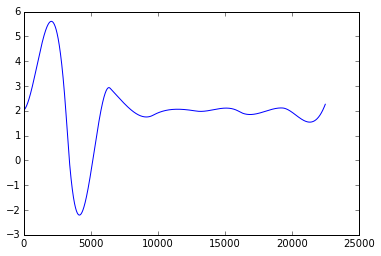

In [9]:
Af = np.pi/4.
wn=0;#which node you're optimizing the boundary time series for
opt1 = PyBC_opt_dh(fi, fc, ndof, x0, wn, Vin, md)#set up instance of optimization class
Q0orig = opt1.getBCtimeseries()
plot(Q0orig)
opt1.compute_f()
f0 = opt1.f
print "f is %f" %f0
print "T is %f" %opt1.T
print "Using %s modes" %opt1.modetype
print T/(7.)
print M

In [10]:
Vin2 = np.trapz(Q0orig, x=t)
print "Vin (specified) = %f" %Vin
print "Vin (acutal) = %f" %Vin2
Q0orig = opt1.getBCtimeseries()


    

Vin (specified) = 120.005333
Vin (acutal) = 120.005334


In [11]:
#solve!
opt1.solve()

In [12]:
print "f is %f" %opt1.f
ff = opt1.f
xf = opt1.x
print "Improvement f_0/f_f is %f" %(ff/f0)
print "components of x_f are\n i    x_i\n******************"
for i in range(len(opt1.x)):
    print "%2d    %f "%(i+1,xf[i]) 

f is 2.924469
Improvement f_0/f_f is 0.993602
components of x_f are
 i    x_i
******************
 1    0.195951 
 2    1.284209 
 3    -3.134404 
 4    2.909793 
 5    -0.214029 
 6    1.825007 
 7    0.108760 
 8    1.991345 
 9    -0.034465 
10    1.969691 
11    -0.117855 
12    2.114696 
13    -0.010261 
14    2.261066 
15    0.532594 


In [13]:
x02 = np.array(opt1.x)
opt2 = PyBC_opt_dh(fi, fc, ndof, x02, wn, Vin, md)
Q02 =opt2.getBCtimeseries()
#from opt1. routine: sumQ = 16.252167, x[0] = 4.526393, Dt = 8.571429, T = 60.000000

15
0
120.005333333
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2.92446900093
2.92446900093
0.0
../indata/dhoptimization.inp
../indata/dhoptimization.config


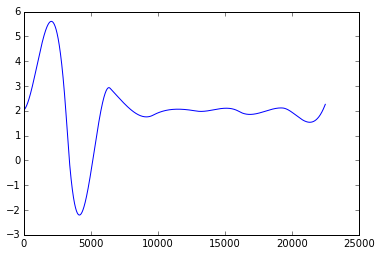

In [14]:
plot(Q02)
print ndof
print md
print Vin
print np.array(opt1.x)-np.array(opt2.x)
opt1.compute_f()
print opt1.f
opt2.compute_f()
print opt2.f
print norm(np.array(opt1.r)-np.array(opt2.r))
print fi
print fc

In [15]:
#make a place to put the data
import os
lucky = 1e6  #you feeling lucky today pal? use this to use include a random number in filename to ensure you don't write over old data
kk = np.int(lucky*np.random.rand())
#where = "../dhdx_results_ndof%d_wavespeed_%03.f_improvement_%f/"%(ndof,n0.a[0],ff/f0)
#where = "/Users/lieba/Desktop/dhdx_case%d_ndof%d_M%dimprovement_%f/"%(case,ndof,opt1.M,ff/f0)
where = "/Users/lieba/Desktop/dhdx_case%d_ndof%d_M%d_start_with%d_impr%f/"%(case,ndof,opt1.M,Mstart,ff/f0)
if not os.path.exists(where):
    os.makedirs(where)

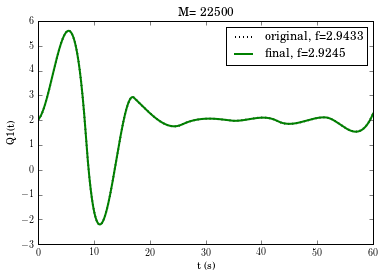

In [16]:
#plot the boundary time series before and after optimization
rc('text', usetex=True)
rc('font', family='serif')
ff = opt1.f
Q01 = opt1.getBCtimeseries()
t = np.linspace(0,opt1.T, opt1.M+1)
fig,ax = plt.subplots(nrows = 1)
ax.plot(t,Q0orig,'k:', linewidth = 2)#,t,np.zeros(opt1.M+1),'r')
ax.plot(t,Q01,'g', linewidth = 2)
ax.set_ylabel('Q1(t)')
s0 = "%.3e"%f0
sf = "%.3e"%ff
w0 = s0.find('e')
wf = sf.find('e')
p0 = int(s0[w0+2:])
pf = int(sf[wf+2:])
legend([r'original, f=%.4f'%f0,'final, f=%.4f'%ff])
#legend([r'original, $f = %s\times10^%1.d$'%(s0[0:w0],p0), r'optimized,$f = %s\times10^%1.d$'%(sf[0:wf],pf)], loc = 'upper right')
ax.set_xlabel('t (s)')
#title('difference is %.6e'% norm(np.array(Q0orig)-np.array(Q01)))
title('M= %d'%M)
savefig(where+"case%d_opt_Q_nodf%d_M%d.eps"%(case,ndof,M), format='eps')

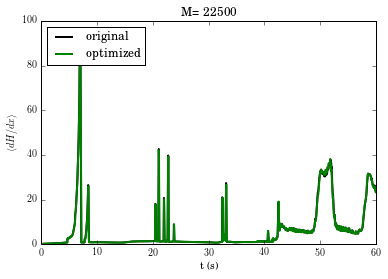

In [17]:
#plot <dH/dx> as a function of time for each bc time series
n2 = PyNetwork(fi, fc, mtype)

n3 = PyNetwork(fi,fc, mtype)
n2.setbVal(0,Q0orig)
n3.setbVal(0,Q01)
n2.runForwardProblem(dt)
n3.runForwardProblem(dt)
xf = opt1.x
Hbar2 = [n2.getAveGradH(i) for i in range(n0.M+1)]
Hbar3 = [n3.getAveGradH(i) for i in range(n0.M+1)]
plot(t,Hbar2, 'k', t,Hbar3,'g', linewidth=2)
ax = gca()
legend(['original', 'optimized'], loc = 'upper left')
ax.set_xlabel('t (s)')
ax.set_ylabel(r"$\langle dH/dx \rangle$")
title('M= %d'%M)
savefig(where+"case%d_opt_dh_nodf%d_M%d.eps"%(case,ndof,M), format='eps')


2.94330131746
2.92446900093
120.011055356
120.011057102


120.00533353322609

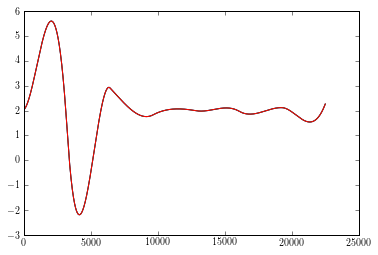

In [18]:
print sum([abs(hi) for hi in Hbar2])/(2.*M)
print sum([abs(hi) for hi in Hbar3])/(2.*M)
Q022 = opt2.getBCTimeSeries2()
plot(Q022)
plot(Q02)
print sum(Q0orig)*dt
print sum(Q01)*dt
plot(Q01)
import scipy
scipy.trapz(Q01,linspace(0,T,M+1))


In [19]:
#save results to a labeled folder 
with open(where+"more_info.txt",'w') as fout:
    fout.write("data (Q0, Qf) pickled to Q0.p and Qf.p\n\n")
    fout.write("to generate whole history, load them and run:\n\
                n0 = PyNetwork(fi,fc, 1)\n\
                n0.setbVal(0,Q)\n\
                n0.runForwardProblem(dt)\n\
                for Q = Q00 or Q = Qf\n\n")
    fout.write("***************************************************************\n")
    fout.write( "interpolation   CPU solve t  actual solve t    f0             ff            ff/f0      Vin   \n")  
    fout.write( "%s         %.2f    %.2f     %e     %e    %.5f   %.2f\n"%(opt1.modetype,opt1.solve_t, opt1.wsolve_t,f0, ff, ff/f0, Vin))
    fout.write("***************************************************************\n")
    fout.write("x0                   xf\n")
    for i in range(len(x0)):
        fout.write("%.15f    %.15f\n"%(x0[i],xf[i]))
import shutil
shutil.copy(fi,where)
shutil.copy(fc,where)
import pickle
pickle.dump(Q00, open(where+"Q0.p", "wb"))
pickle.dump(Q01, open(where+"Qf.p", "wb"))
print "results saved to %s"%where

results saved to /Users/lieba/Desktop/dhdx_case1_ndof15_M22500_start_with15000_impr0.993602/


In [20]:
print "CPU solve t  actual solve t    ff/f0"  
print " %.2f         %.2f         %.5f"%(opt1.solve_t, opt1.wsolve_t,ff/f0)

CPU solve t  actual solve t    ff/f0
 6775.48         912.94         0.99360


In [21]:
M

22500